In [1]:
import scipy as scp
import scipy.sparse
import scipy.sparse.linalg
from scipy.linalg import expm
from scipy.sparse import csr_array

from scipy.integrate import solve_ivp
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import numpy as np

import functools # for functools.reduce
from tqdm import tqdm
import os

from pathlib import Path

import seaborn as sns
import pandas as pd

# Tools


In [2]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))

# Spin operators


In [3]:
sx = 1/2 * scipy.sparse.csr_array([[0.,  1.],[1., 0.]])
sy = 1/2 * scipy.sparse.csr_array([[0., -1.j],[1.j, 0.]])
sz = 1/2 * scipy.sparse.csr_array([[1., 0.],[0., -1.]])

I = scipy.sparse.identity(2)

sp = ((sx + 1.j * sy) / 2).real
sm = ((sx - 1.j * sy) / 2).real

$$
\hat{\sigma}^{z}_{j} = \underbrace{\hat{I}\otimes\hat{I}\dots\hat{I}}_{j-1\ \mathrm{terms}}\otimes\hat{\sigma}^{z}\otimes\underbrace{\hat{I}\otimes\hat{I}\dots\otimes\hat{I}}_{N-j\ \mathrm{terms}},
$$


In [4]:
def sx_j(j, N):
    """
    Compute the operator $X_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $X_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sx] + [I] * (N - j))


def sy_j(j, N):
    """
    Compute the operator $Y_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Y_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sy] + [I] * (N - j))


def sz_j(j, N):
    """
    Compute the operator $Z_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Z_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sz] + [I] * (N - j))


def sp_j(j, N):
    """
    Compute the operator $S^+_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^+_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sp] + [I] * (N - j))


def sm_j(j, N):
    """
    Compute the operator $S^-_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^-_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sm] + [I] * (N - j))


def write_spin_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    os.makedirs(path, exist_ok=True)
    for k in range(1, N+1) :
        s = sx_j(k, N)
        scp.sparse.save_npz(path + f'/sx_k_{k}', s)

        s = sy_j(k, N)
        scp.sparse.save_npz(path + f'/sy_k_{k}', s)

        s = sz_j(k, N)
        scp.sparse.save_npz(path + f'/sz_k_{k}', s)

        s = sp_j(k, N)
        scp.sparse.save_npz(path + f'/sp_k_{k}', s)

        s = sm_j(k, N)
        scp.sparse.save_npz(path + f'/sm_k_{k}', s)


N = 8
write_spin_operators(N)


# Hamiltonian


In [5]:
def H_spin(N, J):
    """
    Compute the Hamiltonian of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    """
    H = 0

    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1

        sx_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sx_k_{i}.npz') 
        sx_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sx_k_{ip1}.npz')

        sy_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sy_k_{i}.npz')
        sy_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sy_k_{ip1}.npz')

        sz_i = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{i}.npz')
        sz_ip1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{ip1}.npz')

        H += J * (sx_i @ sx_ip1 + sy_i @ sy_ip1 + sz_i @ sz_ip1)

    return H

N = 2
J= 1

H = H_spin(N, J)
H.toarray()

array([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j, -0.5+0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j]])

# Lindbladian


Lindblad operators for the 2nd dissipator:


In [6]:
def get_Lks(N) :
    """
    Compute the L_k operators for a N-spin system (2nd dissipator).

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    list of scipy.sparse.csr_matrix
        The L_k operators.

    Note
    ----
    The L_k operators are indexed from 1 to N: get_Lks(N)[k] corresponds to L_k,
    and get_Lks(N)[0] is a dummy value to have the same indexing as in the paper.
    """

    Lks = [None]   # in order to have the same indexing as in the paper: from 1 to N

    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = sp_j(k, N)
        sm_kp1 = sm_j(kp1, N)
        sp_kp2 = sp_j(kp2, N)

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        Lks.append(Lk)

    return Lks



def write_Lk_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
        sm_kp1 = scp.sparse.load_npz(path + f'/sm_k_{kp1}.npz')
        sp_kp2 = scp.sparse.load_npz(path + f'/sp_k_{kp2}.npz')

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        scp.sparse.save_npz(path + f'/Lk_{k}', Lk)



N = 2
write_Lk_operators(N)
# Lks = get_Lks(N)
# Lks


100%|██████████| 2/2 [00:00<00:00, 58.49it/s]


write N=14


In [7]:
# write all operators

# N = 14
# write_spin_operators(N) # 10 min for N=14
# write_Lk_operators(N) # 1h30 for N=14, already done from 1 to 5

check get_Lks and write_Lk give same results


In [8]:
# N = 8
# write_Lk_operators(N)
# Lks = get_Lks(N)

# for k in range(1, N+1) :
#     Lk = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Lk_{k}.npz')
#     assert scp.sparse.linalg.norm(Lk - Lks[k]) == 0

Dissipators:


In [9]:
def dissipator_1(rho, J, N) :
    """
    Compute the 1st dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 1st dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        D += J * (sz_k @ rho @ sz_k - 0.5 * (sz_k @ sz_k @ rho + rho @ sz_k @ sz_k))
    return D


def dissipator_2(rho, J, N) :
    """
    Compute the 2nd dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 2nd dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
        D += J * (Lk @ rho @ Lk.H - 0.5 * (Lk.H @ Lk @ rho + rho @ Lk.H @ Lk))
    return D


rho_test = scipy.sparse.identity(2**N)
dissipator_1(rho_test, J, N), dissipator_2(rho_test, J, N)



(<4x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 0 stored elements (blocksize = 2x2) in Block Sparse Row format>,
 <4x4 sparse matrix of type '<class 'numpy.complex128'>'
 	with 0 stored elements (blocksize = 2x2) in Block Sparse Row format>)

Lindbladian


In [10]:
def lindblad_non_unitary(rho, epsilon, gamma, J, N) :
    """
    Compute the non-unitary part of the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The non-unitary part of the Lindbladian of the system.
    """
    L1 = epsilon * (gamma * dissipator_1(rho, J, N) + (1 - gamma) * dissipator_2(rho, J, N))
    return L1 


def lindblad(rho, H, epsilon, gamma, J, N) :
    """
    Compute the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    H : scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Lindbladian of the system.
    """
    L0 = - 1j * (H @ rho - rho @ H)
    L1 = lindblad_non_unitary(rho, epsilon, gamma, J, N)
    return L0 + L1 


EPSILON = 0.1
GAMMA = 0.5
lindblad(rho_test, H_spin(N, J), EPSILON, GAMMA, J, N)

<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements (blocksize = 2x1) in Block Sparse Row format>

# Quantities useful to define Conserved quantities


In [11]:
def Ob(N) :
    """
    Boost operator

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The boost operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    O = 0


    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1

        sx_i = scp.sparse.load_npz(path + f'/sx_k_{i}.npz')
        sx_ip1 = scp.sparse.load_npz(path + f'/sx_k_{ip1}.npz')

        sy_i = scp.sparse.load_npz(path + f'/sy_k_{i}.npz')
        sy_ip1 = scp.sparse.load_npz(path + f'/sy_k_{ip1}.npz')

        sz_i = scp.sparse.load_npz(path + f'/sz_k_{i}.npz')
        sz_ip1 = scp.sparse.load_npz(path + f'/sz_k_{ip1}.npz')

        O += -1j * i * (sx_i @ sx_ip1 + sy_i @ sy_ip1 + sz_i @ sz_ip1)

    return O


Ob(N)



<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [12]:
def Jh(N, J) :
    """
    Compute the heat current operator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    float
        The value of the JH operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    JH = 0

    for k in range(1, N+1) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sx_k = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
        sx_kp1 = scp.sparse.load_npz(path + f'/sx_k_{kp1}.npz')
        sx_kp2 = scp.sparse.load_npz(path + f'/sx_k_{kp2}.npz')

        sy_k = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
        sy_kp1 = scp.sparse.load_npz(path + f'/sy_k_{kp1}.npz')
        sy_kp2 = scp.sparse.load_npz(path + f'/sy_k_{kp2}.npz')

        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        sz_kp1 = scp.sparse.load_npz(path + f'/sz_k_{kp1}.npz')
        sz_kp2 = scp.sparse.load_npz(path + f'/sz_k_{kp2}.npz')

        S_k = [sx_k, sy_k, sz_k]
        S_kp1 = [sx_kp1, sy_kp1, sz_kp1]
        S_kp2 = [sx_kp2, sy_kp2, sz_kp2]

        # just to make the formula of the cross product more readable
        u = S_k
        v = S_kp1
        S_cross = [
            u[1] @ v[2] - u[2] @ v[1], 
            u[2] @ v[0] - u[0] @ v[2], 
            u[0] @ v[1] - u[1] @ v[0],
        ]
        JH += J**2 * (S_cross[0] @ S_kp2[0] + S_cross[1] @ S_kp2[1] + S_cross[2] @ S_kp2[2])
    
    return JH


Jh(N, J)



<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [13]:
def compute_operators(N) :
   
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    
    try :
        files = os.listdir(path)
    except FileNotFoundError :
        write_spin_operators(N)
        write_Lk_operators(N)

    try :
        for k in range(1, N+1) :
            sx = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
            sy = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
            sz = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
            sp = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
            sm = scp.sparse.load_npz(path + f'/sm_k_{k}.npz')
    except FileNotFoundError :
        write_spin_operators(N)


    try :
        for k in range(1, N+1) :
            Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
    except FileNotFoundError :
        write_Lk_operators(N)

# compute_operators(N)

In [74]:
# Hyperparameters
N = 4
J = 1
EPSILON = 0.1
GAMMA = 0.8

compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Debug


In [75]:
N = 4
compute_operators(N)
C2_tmp = H_spin(N, J).toarray()
C3_tmp = Jh(N, J).toarray()
Ob_val_tmp = Ob(N).toarray()
C4_tmp = (Ob_val_tmp @ C3_tmp - C3_tmp @ Ob_val_tmp)
C5_tmp = (Ob_val_tmp @ C4_tmp - C4_tmp @ Ob_val_tmp)

In [76]:
# display((C2_tmp == C2).all())
# display((C3_tmp == C3).all())
# display((Ob_val_tmp == Ob_val).all())
# display((C4_tmp == C4).all())
# display((C5_tmp == C5).all())
display(((C4 @ C2 - C2 @ C4).toarray() == np.zeros_like(C2)).all())

False

In [77]:
C4 = Ob_val * C3 - C3 * Ob_val
C5 = Ob_val @ C4 - C4 @ Ob_val
display(((C4 @ C2 - C2 @ C4).toarray() == np.zeros_like(C2)).all())
display(((C5 @ C2 - C2 @ C5).toarray() == np.zeros_like(C2)).all())

False

False

In [78]:
((C4_tmp @ C2_tmp - C2_tmp @ C4_tmp) == np.zeros_like(C2_tmp)).all()

False

# GGE


In [15]:
def GGE(lagr, conserved_quantities) :
    """
    Compute the Generalized Gibbs Ensemble (GGE) density matrix, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The GGE density matrix.
    """    
    exponent = 0
    for lambda_i, C_i in zip(lagr, conserved_quantities) :
        exponent -= lambda_i * C_i

    U = exp_mat(exponent)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

test_GGE = GGE([1, 1, 1, 1], Cs); test_GGE

<256x256 sparse array of type '<class 'numpy.complex128'>'
	with 12870 stored elements in Compressed Sparse Row format>

In [16]:
def avg_GGE(lagr, conserved_quantities, O) :
    """
    Compute the average of an observable in the Generalized Gibbs Ensemble (GGE), given the Lagrange multipliers, the conserved quantities, and the observable.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable in the GGE.
    """
    rho = GGE(lagr, conserved_quantities)
    return scp.sparse.csr_matrix.trace(rho @ O)

avg_GGE([1] * len(Cs), Cs, sp_j(1, N))

0j

# EOM Lagrange multipliers


In [17]:
def chi(lagr, conserved_quantities) :
    """
    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The susceptibility of the observable in the GGE.
    """
    n = len(conserved_quantities)
    chi_mat = np.zeros((n, n))
    for i in range(n) :
        for j in range(n) :
            chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \
                            - avg_GGE(lagr, conserved_quantities, conserved_quantities[i]) * avg_GGE(lagr, conserved_quantities, conserved_quantities[j])
    return chi_mat
    

def force(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE = GGE(lagr, conserved_quantities)

    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :
        vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f


display(chi([0]*len(Cs), Cs))

force([0]*len(Cs), Cs)

C:\Users\antho\AppData\Local\Temp\ipykernel_16624\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([[  1.5   ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.75  ,   0.    , -11.625 ],
       [  0.    ,   0.    ,  11.625 ,   0.    ],
       [  0.    , -11.625 ,   0.    , 663.1875]])

C:\Users\antho\AppData\Local\Temp\ipykernel_16624\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))


array([0.        , 0.00041667, 0.        , 0.        ])

# Néel configuration


up, down, up, down, ...


In [18]:
def generate_neel(N) :
    """
    Generate the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """
    up = np.array([1, 0])
    down = np.array([0, 1])

    state = 1

    # starts with up
    for i in range(1, N+1) :
        if i % 2 == 1 :
            state = np.kron(state, up)
        else :
            state = np.kron(state, down)

    rho = scp.sparse.csr_matrix(state).T @ scp.sparse.csr_matrix(state)
    return rho


N = 8
GGE_neel = generate_neel(8).toarray(); display(GGE_neel)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

array([ 1.58283761e+00, -3.51419571e-05,  6.02500328e-06, -9.55266726e-07])

'Total Spin Sz: 0j'

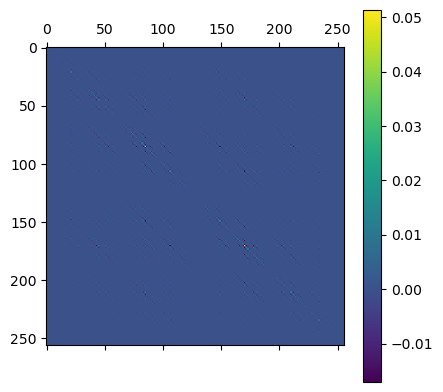

In [19]:
def find_lagr_closest_GGE(rho, conserved_quantities) :
    """
    Find the closest GGE density matrix to the Neel state, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix to be written in the GGE formalism.
    lagr : list of float
        The Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The closest GGE density matrix to the Neel state.
    """

    solution = fmin(lambda x: np.linalg.norm(GGE(x, conserved_quantities).toarray() - rho), x0=np.zeros(len(conserved_quantities)), disp=False)
    return solution


def fetch_neel(N) :
    """
    Fetch the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """

    try :
        lambdas_0 = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt')
    except FileNotFoundError :
        GGE_neel = generate_neel(N)
        lambdas_0 = find_lagr_closest_GGE(GGE_neel, Cs)
        np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt', lambdas_0)
    return lambdas_0



GGE_neel = generate_neel(N)
lambdas_GGE_neel = find_lagr_closest_GGE(GGE_neel, Cs); display(lambdas_GGE_neel)

total_spin = 0
for j in range(1, N+1) :
    total_spin += avg_GGE(lambdas_GGE_neel, Cs, sp_j(j, N))
display(f"Total Spin Sz: {total_spin}")

plt.matshow(GGE(lambdas_GGE_neel, Cs).toarray().real)
plt.colorbar()
plt.savefig('results/time_dependent_GGE/heisenberg_spins/GGE_neel.png')

# Numerical integration


In [20]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Initial conditions
lambdas_0 = fetch_neel(N)

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)


## Exact time evolution


In [21]:
def avg_general(rho, O) :
    """
    Compute the average of an observable in a density matrix.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix.
    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable.
    """
    return scp.sparse.csr_matrix.trace(rho @ O)


def time_evolution(rho0, H, epsilon, gamma, J, N, t) :
    """
    Compute the time evolution of a density matrix, given the initial density matrix, the Hamiltonian, the perturbation strength, the relative strength, the coupling constant, the number of spins, and the time.

    Parameters
    ----------
    rho0 : scipy.sparse.csr_matrix
        The initial density matrix.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins.
    t : float
        The time.

    Returns
    -------
    scipy.sparse.csr_matrix
        The density matrix at time t.
    """
    def f(t, rho) :
        return lindblad(rho.reshape(H.shape), H, epsilon, gamma, J, N).flatten()

    rho0 = rho0.toarray()
    sol = solve_ivp(f, [0, t[-1]], rho0.flatten(), t_eval=t, method='RK45')
    return sol


def get_rhos_exact(shape) :
    rhos_re = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real.npz').T.toarray().reshape((-1, *shape))
    rhos_im = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im.npz').T.toarray().reshape((-1, *shape))
    return rhos_re + 1j * rhos_im




compute


In [ ]:
lambdas_0 = fetch_neel(N)
GGE_neel = GGE(lambdas_0, Cs)
Hs = H_spin(N, J)

sol_exact = time_evolution(GGE_neel, Hs, EPSILON, GAMMA, J, N, t_eval)

os.makedirs(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}', exist_ok=True)
np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt', sol_exact.t)
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real', csr_array(sol_exact.y.real))
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im', csr_array(sol_exact.y.imag))

#### Observables


In [22]:
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

compute


In [334]:
rhos_exact = get_rhos_exact(H.shape)


# Average current
JHs = []
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    JHs.append(avg_general(rho_exact, Jh(N, J)))

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt', -np.array(JHs).real / N)


# Spin neighbor correlation
Y_spin_cor = []

j = 3
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    avg_corr = avg_general(rho_exact, sz_j @ sz_jp1) 
    Y_spin_cor.append(-4 * avg_corr)

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt', np.array(Y_spin_cor).real)



Plot


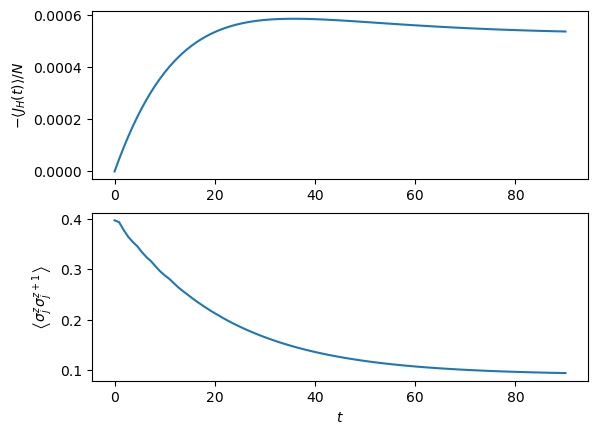

In [8]:
plt.subplot(211)
JHs = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')
plt.plot(ts, JHs)
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
# plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.pdf")


plt.subplot(212)
spin_corr = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
plt.plot(ts, spin_corr)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_exact.pdf")

## GGE evolution


Compute


In [ ]:
F = lambda t, s: force(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_0, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", all_params)

C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))
C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


### Observables


In [23]:
time_dependent_params = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [40]:
# Heat current
Y = []
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


# spin neighbor correlation
j = 3

Y = []
for i, t in enumerate(t_eval) :
    sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
    sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

    avg_corr = avg_GGE(lagr.T[i], Cs, sz_j @ sz_jp1) 
    Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", np.vstack([t_eval, np.array(Y)]).T.real)



Plot


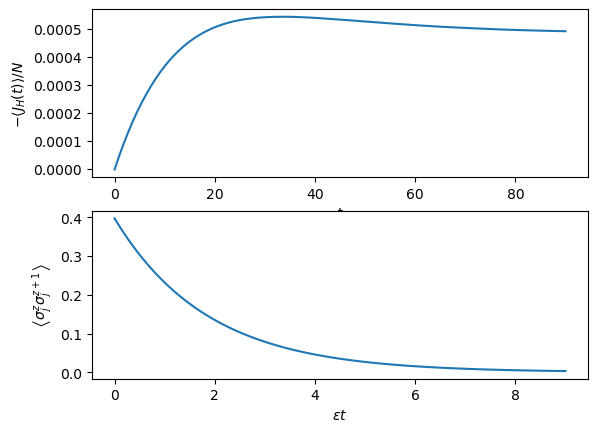

In [41]:
plt.subplot(211)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 


plt.subplot(212)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", unpack=True)

plt.plot(EPSILON * t_eval, Y)
plt.xlabel(r'$\epsilon t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')


plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_GGE.pdf")

## Comparison Exact vs GGE


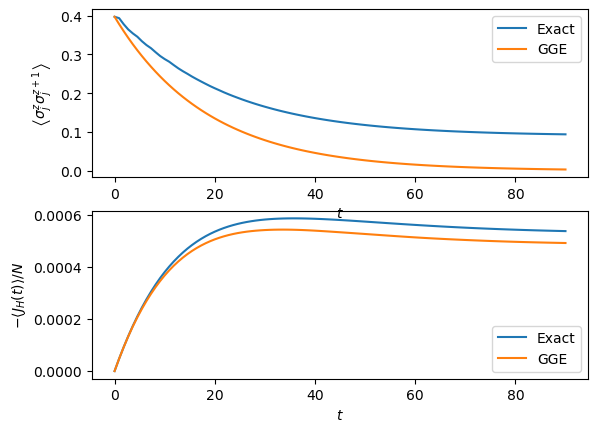

In [14]:
plt.subplot(2, 1, 2)

t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.legend()



plt.subplot(2, 1, 1)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", unpack=True)
Y_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

plt.plot(ts, Y_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_exact_VS_GGE.pdf")


# Without spin operators


### Computation first derivative $<\dot C_j>$


In [21]:
def init_lambdas(N, dt) :
    """
    Initialize the Lagrange multipliers for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    numpy.ndarray
        The Lagrange multipliers.
    """
    lambdas_0 = fetch_neel(N)
    lambdas_1 = lambdas_0 + dt * force(lambdas_0, Cs)


    rho_GGE_0 = GGE(lambdas_0, Cs)
    Cjs_0 = np.zeros(len(Cs))
    for j in range(len(Cs)) :
        Cjs_0[j] = scp.sparse.csr_matrix.trace(Cs[j] @ rho_GGE_0)
    np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/Cjs.txt", Cjs_0)
    return lambdas_0, lambdas_1

In [22]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)

# Initial conditions
dt = t_eval[1] - t_eval[0]
lambdas_0, lambdas_1 = init_lambdas(N, dt)


C:\Users\antho\AppData\Local\Temp\ipykernel_16624\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))
C:\Users\antho\AppData\Local\Temp\ipykernel_16624\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \
C:\Users\antho\AppData\Local\Temp\ipykernel_16624\303644710.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  Cjs_0[j] = scp.sparse.csr_matrix.trace(Cs[j] @ rho_GGE_0)


In [25]:
def force_2(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE_current = GGE(lagr, conserved_quantities)
    Cjs_old = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/Cjs.txt")
    Cjs_new = np.zeros_like(Cjs_old)


    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :
        Cjs_new[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ rho_GGE_current)
        vect[j] = (Cjs_new[j] - Cjs_old[j]) / dt
    np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/Cjs.txt", Cjs_new)

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f


display(force_2([0]*len(Cs), Cs))

C:\Users\antho\AppData\Local\Temp\ipykernel_15892\4090725142.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Cjs_new[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ rho_GGE_current)
C:\Users\antho\AppData\Local\Temp\ipykernel_15892\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([-1.74645425e+00,  3.50262142e-05, -6.34599840e-06,  9.70315329e-07])

Compute


In [400]:
print(lambdas_0)
print(lambdas_1)

[ 1.58283761e+00 -3.51419571e-05  6.02500328e-06 -9.55266726e-07]
[1.46951583e+00 5.62221596e-04 5.25270305e-06 8.77410193e-07]


In [398]:
print(lambdas_0)


F = lambda t, s: force_2(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_1, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
all_params[:,0] += dt
all_params = np.insert(all_params, 0, np.insert(lambdas_0, 0, 0), axis=0)

os.makedirs("results/time_dependent_GGE/heisenberg_spins/force_2", exist_ok=True)
np.savetxt("results/time_dependent_GGE/heisenberg_spins/force_2/time_dependent_params.txt", all_params)



[ 1.58283761e+00 -3.51419571e-05  6.02500328e-06 -9.55266726e-07]
[-2.38152852e+00  1.36270409e-05 -6.70656649e-05  2.14837506e-04]


C:\Users\antho\AppData\Local\Temp\ipykernel_10352\3215592198.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  Cjs_new[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ rho_GGE_current)
C:\Users\antho\AppData\Local\Temp\ipykernel_10352\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


[-2.25925684e+00 -4.03566002e-04 -6.21381499e-05  6.17582404e-03]
[-2.25571485e+00 -4.15653779e-04 -6.20027832e-05  6.35332974e-03]
[-2.25745585e+00 -4.09711634e-04 -6.20693901e-05  6.26606501e-03]
[-2.25861053e+00 -4.05771282e-04 -6.21134343e-05  6.20817271e-03]
[-2.25025466e+00 -4.34297396e-04 -6.17933471e-05  6.62738625e-03]
[-2.23196874e+00 -4.96810605e-04 -6.10818809e-05  7.54680160e-03]
[-2.23298638e+00 -4.93329320e-04 -6.11217422e-05  7.49555153e-03]
[-2.25851235e+00 -4.06106957e-04 -6.21095181e-05  6.21306163e-03]
[-2.25928417e+00 -4.03469755e-04 -6.21377876e-05  6.17344724e-03]
[-2.25882810e+00 -4.05028055e-04 -6.21210363e-05  6.19683142e-03]
[-2.26160225e+00 -3.95550722e-04 -6.22238063e-05  6.05510016e-03]
[-2.26772726e+00 -3.74637127e-04 -6.24492652e-05  5.74234531e-03]
[-2.26746392e+00 -3.75536167e-04 -6.24394377e-05  5.75571811e-03]
[-2.25880116e+00 -4.05120352e-04 -6.21201907e-05  6.19829544e-03]
[-2.25815158e+00 -4.07338792e-04 -6.20974964e-05  6.23208539e-03]
[-2.258502

### Observables


In [427]:
folder = 'force_2'
time_dependent_params = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [428]:
# Heat current
Y = []
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


# spin neighbor correlation
j = 3

Y = []
for i, t in enumerate(t_eval) :
    sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
    sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

    avg_corr = avg_GGE(lagr.T[i], Cs, sz_j @ sz_jp1) 
    Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/spin_neighbor_correlation.txt", np.vstack([t_eval, np.array(Y)]).T.real)



Plot


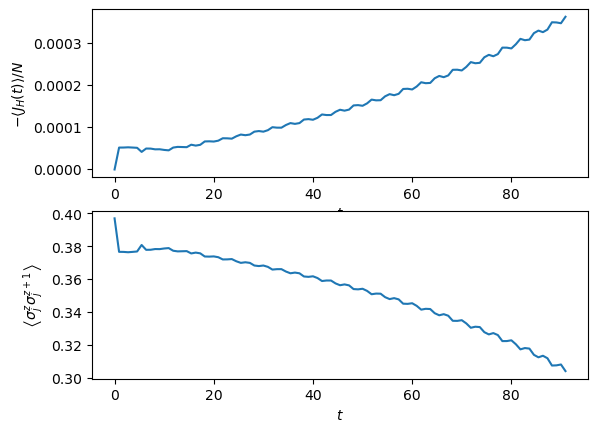

In [430]:
plt.subplot(211)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/avg_current.txt", unpack=True)

plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 


plt.subplot(212)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/spin_neighbor_correlation.txt", unpack=True)

plt.plot(t_eval, Y)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')


plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/{folder}/observables_GGE.pdf")

# Comparison with minimisation of $||L \rho ||$


In [23]:
def lindblad_norm(lagr, conserved_quantities, H, epsilon, gamma, J, N) :
    # check that lagr has not NaN values
    assert not np.isnan(lagr).any()
    rho_GGE = GGE(lagr, conserved_quantities)
    return np.linalg.norm(lindblad(rho_GGE,  H, epsilon, gamma, J, N).toarray(), 'nuc')

def lindblad_norm_log(lagr, conserved_quantities, H, epsilon, gamma, J, N) :
    rho_GGE = GGE(lagr, conserved_quantities)
    return np.log(np.linalg.norm(lindblad(rho_GGE,  H, epsilon, gamma, J, N).toarray(), 'nuc') + TOL)

lambdas_0 = fetch_neel(N)
Hs = H_spin(N, J)
lindblad_norm(lambdas_0, Cs, Hs, EPSILON, GAMMA, J, N)


0.13196521040906622

In [24]:
def optimize(l, lagr_0, conserved_quantities, H, epsilon, gamma, J, N) :
    '''
    Parameters
    ----------
    l : function
        The function to minimize.
    lagr_0 : list of float
        The initial Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Note
    ----
    fmin[0]     # xopt 
    fmin[1]     # fopt
    fmin[2]     # nb iteration
    fmin[3]     # funcalls
    fmin[4]     # warnflag
    fmin[5]     # solution at each iterations
    '''
    sols = {}
    solution = fmin(lambda x: l(x, conserved_quantities, H, epsilon, gamma, J, N), lagr_0, retall=True, full_output=True)
    sols['history'] = np.array(solution[5])
    sols['lagr_best'] = solution[0]
    sols['rho_best'] = GGE(sols['lagr_best'], conserved_quantities)
    sols['fopt'] = np.array([solution[1]])

    np.savetxt(f'{folder}/history.txt', sols['history'])
    np.savetxt(f'{folder}/loss_rho_best.txt', sols['fopt'])
    np.savetxt(f'{folder}/lagr_best.txt', sols['lagr_best'])
    np.savetxt(f'{folder}/rho_best.txt', np.atleast_1d(sols['rho_best'].toarray()))

    return sols

In [25]:
folder = 'results/time_dependent_GGE/heisenberg_spins/variational'
os.makedirs(folder, exist_ok=True)

l = lindblad_norm
lagr_0 = fetch_neel(N)
conserved_quantities = Cs
H = H_spin(N, J)



Compute


In [30]:
optimize(l, lagr_0, conserved_quantities, H, EPSILON, GAMMA, J, N)

Optimization terminated successfully.
         Current function value: -6.535283
         Iterations: 66
         Function evaluations: 121


{'history': array([[ 1.58283761e+00, -3.51419571e-05,  6.02500328e-06,
         -9.55266726e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.42455385e+00, -3.64597805e-05,  6.25094091e-06,
         -9.91089228e-07],
        [ 1.31573377e+00, -3.53890490e-05,  6.34978862e-06,
         -1.09631783e-06],
        [ 1.11540588e+00, -3.55743679e-05,  6.59337762e-06,
         -1.07075698e-06],
        [ 1.11540588e+00, -3.55743679e-05,  6.59337762e-06,
         -1.07075698e-06],
        [ 8.30680599e-01, -3.80341333e-05,  7.17807947e-06,
         -1.15096114e-06],
        [ 4.64417540e-01, -3.67988884e-05,  7.30858934e-06,
         -1.32459882e-06],
        [ 4.64417540e-01, -3.67988884e-05,  7.30858934e-06,
         -1.32459882e-06],
        [-1.53830098e-01, -3.70642387e-05,  8.72704754e-06,
         -1.39449250e-06],
        [-1.53830098e-01, -3.706

Plot


In [31]:
lambdas_inf = np.loadtxt(f'{folder}/lagr_best.txt')

# Heat current
Y = []
avg_current = avg_GGE(lambdas_inf, Cs, -Jh(N, J)) / N
Y.append(avg_current)

np.savetxt(f"{folder}/avg_current.txt", np.atleast_1d(Y).real)


# spin neighbor correlation
j = 3

Y = []
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

avg_corr = avg_GGE(lambdas_inf, Cs, sz_j @ sz_jp1) 
Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt(f"{folder}/spin_neighbor_correlation.txt", np.atleast_1d(Y).real)


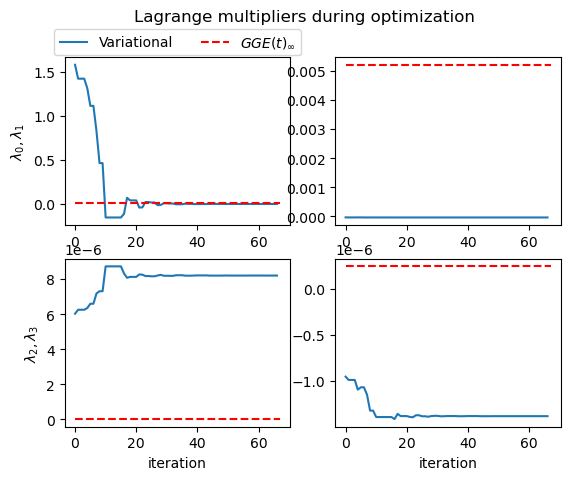

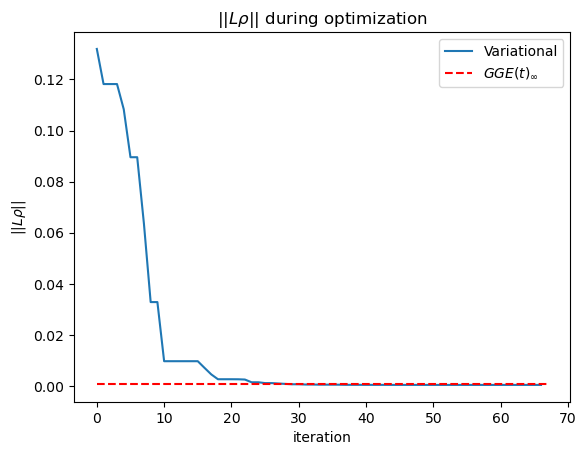

In [32]:
lambdas_history = np.loadtxt(f'{folder}/history.txt').T
lambdas_GGE = np.loadtxt('results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt', unpack=True)
lambdas_GGE_inf = lambdas_GGE.T[-1][1:]



plt.subplot(221)
plt.plot(lambdas_history[0], label='Variational')
plt.hlines(lambdas_GGE[1][-1], 0, len(lambdas_history[0]), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$\lambda_0, \lambda_1$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=2)

plt.subplot(222)
plt.plot(lambdas_history[1])
plt.hlines(lambdas_GGE[2][-1], 0, len(lambdas_history[1]), color='red', linestyle='--')

plt.subplot(223)
plt.plot(lambdas_history[2])
plt.hlines(lambdas_GGE[3][-1], 0, len(lambdas_history[2]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_2, \lambda_3$')

plt.subplot(224)
plt.plot(lambdas_history[3])
plt.hlines(lambdas_GGE[4][-1], 0, len(lambdas_history[3]), color='red', linestyle='--')
plt.xlabel('iteration')


plt.suptitle('Lagrange multipliers during optimization')
plt.savefig(f"{folder}/lagr_multipliers_afo_iterations.pdf")


plt.figure()
norms = []
for i, lagr in enumerate(lambdas_history.T) :
    norm_i = lindblad_norm(lagr, Cs, H, EPSILON, GAMMA, J, N)
    norms.append(norm_i)
gge_norms = lindblad_norm(lambdas_GGE_inf, Cs, H, EPSILON, GAMMA, J, N)
plt.plot(norms, label='Variational')
plt.hlines(gge_norms, 0, len(norms), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$||L \rho||$')
plt.xlabel('iteration')

plt.legend()
plt.title(r'$||L \rho||$ during optimization')
plt.savefig(f"{folder}/lindblad_norm_afo_iterations.pdf")



Plot


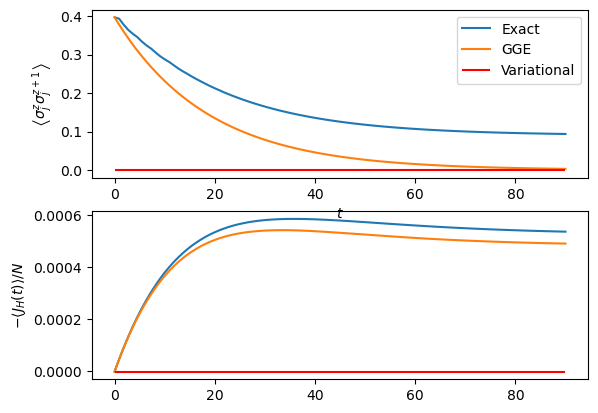

In [33]:
plt.subplot(2, 1, 2)

t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')

val_variational = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/variational/avg_current.txt")

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.hlines(val_variational, 0, t_eval[-1], label='Variational', color='r')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 



plt.subplot(2, 1, 1)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", unpack=True)
Y_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

val_variational = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/variational/spin_neighbor_correlation.txt")

plt.plot(ts, Y_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.hlines(val_variational, 0, t_eval[-1], label='Variational', color='r')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()
plt.savefig("results/time_dependent_GGE/heisenberg_spins/variational/observables_exact_VS_GGE.pdf")


## test from various initial conditions


In [28]:
def init_random_lambdas(bounds, Nrep) :
    """
    Initialize the Lagrange multipliers for a N-spin system with random values within the bounds.
    Returns a list of sets of Lagrange multipliers.

    Parameters
    ----------
    bounds : list of tuple
        The bounds for each Lagrange multiplier.
    Nrep : int
        The number of sets of Lagrange multipliers.

    Returns
    -------
    list of numpy.ndarray
        The Lagrange multipliers.
    """
    bounds_ = np.array(bounds).T
    lambdas_0 = []
    for i in range(Nrep) :
        lambdas_0.append(np.random.uniform(low=bounds_[0], high=bounds_[1], size=(1,len(Cs)))[0])
    return lambdas_0

In [199]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)

# Initial conditions
dt = t_eval[1] - t_eval[0]


In [200]:
folder_path = 'results/time_dependent_GGE/heisenberg_spins/variational'

bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]
Nrep = 100
lambdas_0 = init_random_lambdas(bounds, Nrep)

l = lindblad_norm
conserved_quantities = Cs
H = H_spin(N, J)

Compute


In [198]:
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0)) :
    folder = f'{folder_path}/rep_{i_rep}'
    os.makedirs(folder, exist_ok=True)
    optimize(l, lagr_0, conserved_quantities, H, EPSILON, GAMMA, J, N)

Plot


40it [00:00, 91.98it/s] 


Text(0, 0.5, '$\\lambda_3$')

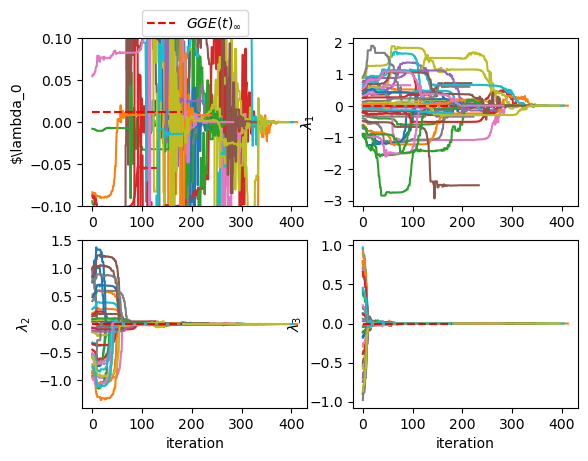

In [262]:
last_rep = 40

for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lambdas_history = np.loadtxt(f'{folder}/history.txt').T

    plt.subplot(221)
    plt.plot(lambdas_history[0])

    plt.subplot(222)
    plt.plot(lambdas_history[1])

    plt.subplot(223)
    plt.plot(lambdas_history[2])

    plt.subplot(224)
    plt.plot(lambdas_history[3])


lambdas_GGE = np.loadtxt('results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt', unpack=True)
lambdas_GGE_inf = lambdas_GGE.T[-1][1:]

plt.subplot(221)
plt.hlines(lambdas_GGE[1][-1], 0, len(lambdas_history[0]), color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.ylabel(r'$\lambda_0')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=2)
plt.ylim(-0.1, 0.1)

plt.subplot(222)
plt.ylabel(r'$\lambda_1$')
plt.hlines(lambdas_GGE[2][-1], 0, len(lambdas_history[1]), color='red', linestyle='--')

plt.subplot(223)
plt.hlines(lambdas_GGE[3][-1], 0, len(lambdas_history[2]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_2$')

plt.subplot(224)
plt.hlines(lambdas_GGE[4][-1], 0, len(lambdas_history[3]), color='red', linestyle='--')
plt.xlabel('iteration')
plt.ylabel(r'$\lambda_3$')
    

In [263]:
collect_lagr_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    collect_lagr_best.append(lagr_best)

collect_lagr_best = np.array(collect_lagr_best)

40it [00:00, 940.48it/s]


In [264]:
collect_lagr_best.T.shape

(4, 40)

In [265]:
collect_loss_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    loss_best = np.loadtxt(f'{folder}/loss_rho_best.txt')
    collect_loss_best.append(loss_best)

collect_loss_best = np.array(collect_loss_best)

40it [00:00, 733.26it/s]


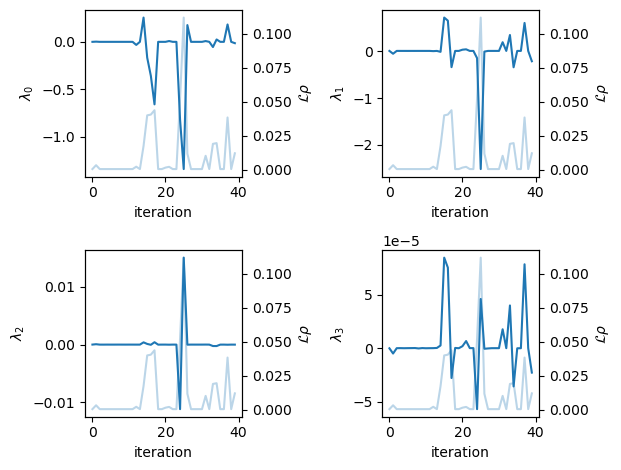

In [275]:

plt.subplot(221)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[0], label=r'$\lambda_0$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_0$')
ax.set_xlabel('iteration')

plt.subplot(222)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[1], label=r'$\lambda_1$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_1$')
ax.set_xlabel('iteration')

plt.subplot(223)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[2], label=r'$\lambda_0$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_ylabel(r'$\lambda_2$')
ax.set_xlabel('iteration')

plt.subplot(224)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3)
ax.plot(collect_lagr_best.T[3], label=r'$\lambda_1$')
ax.set_ylabel(r'$\lambda_3$')
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel('iteration')

fig = plt.gcf()
fig.tight_layout()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/lagr_vs_iteration.pdf")


In [267]:
collect_JH_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    avg_current = avg_GGE(lagr_best, Cs, -Jh(N, J)) / N
    collect_JH_best.append(avg_current)

collect_JH_best = np.array(collect_JH_best)

40it [01:01,  1.55s/it]


percentage close to GGE: 60.0% (tolerance: 0.0001)


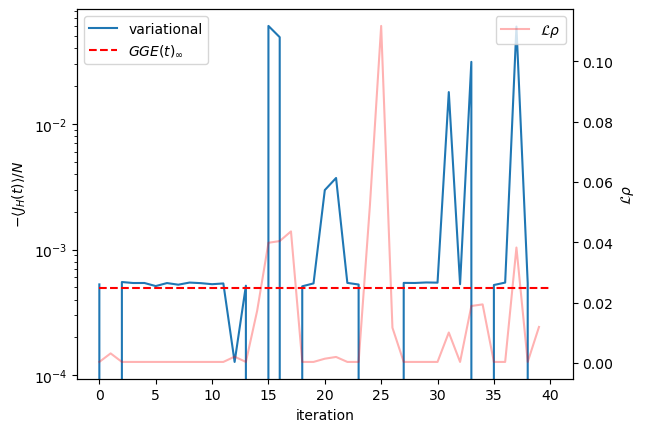

In [270]:
_, current_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

last = current_time_evol[-1]

plt.plot(collect_JH_best.real, label='variational')
plt.hlines(last, 0, last_rep, color='red', linestyle='--', label=r'$GGE(t)_\infty$')
plt.xlabel('iteration')
# plt.ylim(0.00045, 0.00055)
plt.yscale('log')
plt.ylabel(r'$-\left< J_H(t) \right> / N$')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(collect_loss_best, alpha=0.3, label=r'$\mathcal{L}\rho$', color='red')
ax2.set_ylabel(r'$\mathcal{L}\rho$')

ax.legend(loc='upper left')
ax2.legend()

tol_close = 10**(-4)
isclose = np.abs(collect_JH_best - last) < tol_close
print(f'percentage close to GGE: {np.sum(isclose) / len(isclose) * 100}% (tolerance: {tol_close})')

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


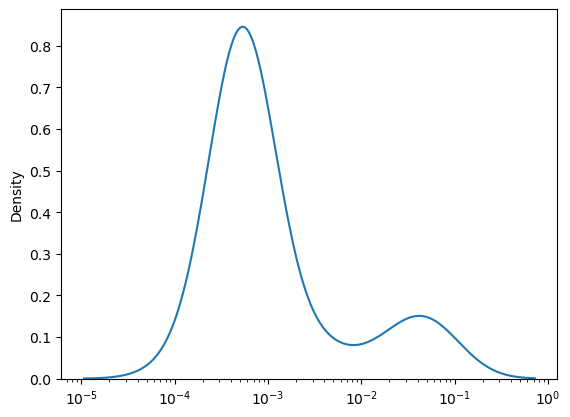

In [269]:
kde = sns.kdeplot(data=collect_JH_best.real, log_scale=True)


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


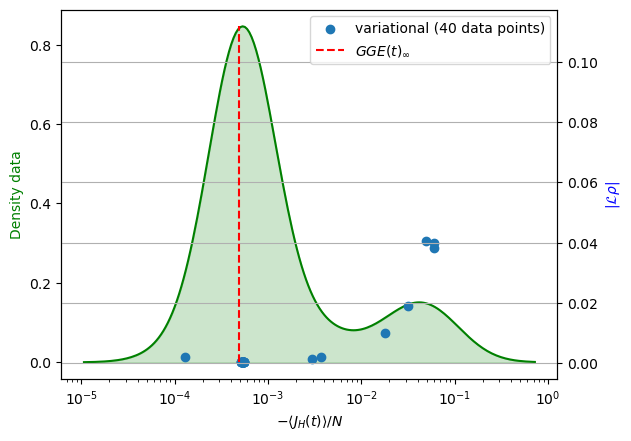

In [279]:
ax1 = plt.gca()
ax2 = ax1.twinx()

xkde = kde.lines[0].get_xdata()
ykde = kde.lines[0].get_ydata()

ax1.plot(xkde, ykde, color='green')
ax1.set_ylabel('Density data', color='green')
ax1.fill_between(xkde, ykde, color='green', alpha=0.2, zorder=-1)



plt.scatter(collect_JH_best, collect_loss_best, label=f'variational ({len(collect_JH_best)} data points)', zorder=1)


_, current_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/avg_current.txt", unpack=True)
last = current_time_evol[-1]
y_min = min(collect_loss_best)
y_max = max(collect_loss_best)
ax2.vlines(last, y_min, y_max, color='red', linestyle='--', label=r'$GGE(t)_\infty$')


ax2.set_ylabel(r'$|\mathcal{L}\rho|$', color='blue')
ax1.set_xlabel(r'$-\left< J_H(t) \right> / N$')
ax2.set_xscale('log')
ax2.grid()
ax2.legend()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/JH_vs_loss.pdf")

In [276]:
j = 3
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

collect_spincorr_best = []
for i_rep, lagr_0 in tqdm(enumerate(lambdas_0[:last_rep])) :
    folder = f'{folder_path}/rep_{i_rep}'
    lagr_best = np.loadtxt(f'{folder}/lagr_best.txt')
    avg_spincorr = avg_GGE(lagr_best, Cs, sz_j @ sz_jp1)
    collect_spincorr_best.append(-4 * avg_spincorr)

collect_spincorr_best = np.array(collect_spincorr_best)

40it [00:02, 15.25it/s]


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


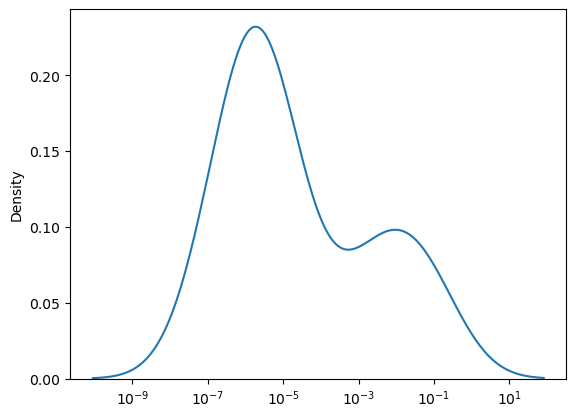

In [281]:
kde = sns.kdeplot(data=collect_spincorr_best.real, log_scale=True)


c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


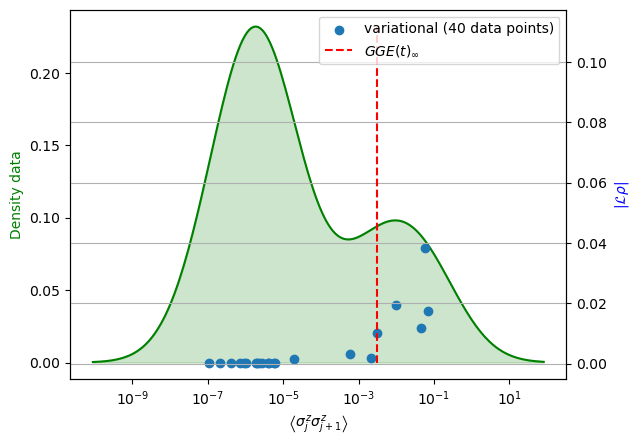

In [282]:
ax1 = plt.gca()
ax2 = ax1.twinx()

xkde = kde.lines[0].get_xdata()
ykde = kde.lines[0].get_ydata()

ax1.plot(xkde, ykde, color='green')
ax1.set_ylabel('Density data', color='green')
ax1.fill_between(xkde, ykde, color='green', alpha=0.2, zorder=-1)



plt.scatter(collect_spincorr_best, collect_loss_best, label=f'variational ({len(collect_spincorr_best)} data points)', zorder=1)


_, corr_time_evol = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/spin_neighbor_correlation.txt", unpack=True)
last = corr_time_evol[-1]
y_min = min(collect_loss_best)
y_max = max(collect_loss_best)
ax2.vlines(last, y_min, y_max, color='red', linestyle='--', label=r'$GGE(t)_\infty$')


ax2.set_ylabel(r'$|\mathcal{L}\rho|$', color='blue')
ax1.set_xlabel(r'$\left< \sigma_j^z \sigma_{j+1}^z \right>$')
ax2.set_xscale('log')
ax2.grid()
ax2.legend()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/variational/spincorr_vs_loss.pdf")

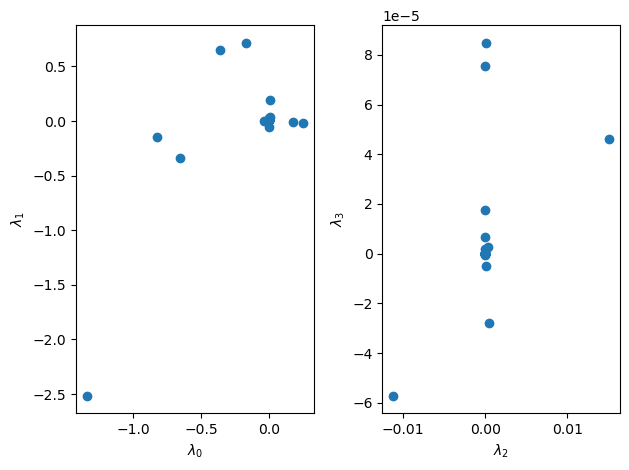

In [75]:

plt.subplot(121)
ax = plt.gca()
ax.scatter(collect_lagr_best.T[0], collect_lagr_best.T[1])
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel(r'$\lambda_0$')
ax.set_ylabel(r'$\lambda_1$')

plt.subplot(122)
ax = plt.gca()
ax.scatter(collect_lagr_best.T[2], collect_lagr_best.T[3])
ax2.set_ylabel(r'$\mathcal{L}\rho$')
ax.set_xlabel(r'$\lambda_2$')
ax.set_ylabel(r'$\lambda_3$')

fig = plt.gcf()
fig.tight_layout()

# Trial using optical-Bloch-like equations


### Sympy part, to compute big matrices only once


In [175]:
# J_smp = smp.symbols('J', real=True, positive=True)

# X_smp = smp.Matrix([[0, 1], [1, 0]])
# Y_smp = smp.Matrix([[0, -smp.I], [smp.I, 0]])
# Z_smp = smp.Matrix([[1, 0], [0, -1]])
# I_smp = smp.Matrix([[1, 0], [0, 1]])

# Sx = hbar/2 * X_smp
# Sy = hbar/2 * Y_smp
# Sz = hbar/2 * Z_smp

In [176]:
# def spin_j_smp(j, N):

#     Sx = smp.KroneckerProduct()
#     Sy = smp.KroneckerProduct()
#     Sz = smp.KroneckerProduct()

#     true_j = j % N

#     if true_j == 0:
#         true_j = N

#     for i in range(1, N+1):
#         if i == true_j:
#             Sx = smp.KroneckerProduct(Sx, X_smp)
#             Sy = smp.KroneckerProduct(Sy, Y_smp)
#             Sz = smp.KroneckerProduct(Sz, Z_smp)
#         else:
#             Sx = smp.KroneckerProduct(Sx, I_smp)
#             Sy = smp.KroneckerProduct(Sy, I_smp)
#             Sz = smp.KroneckerProduct(Sz, I_smp)

#     return Sx.doit(), Sy.doit(), Sz.doit()

# Sx, Sy, Sz = spin_j_smp(4, 4)
# Sy

In [177]:
# def Jh_smp(N) :
#     Jh = smp.zeros(2**N)
#     isfirst = True
#     for j in range(1, N+1):
#         if isfirst:
#             Sxj, Syj, Szj = spin_j_smp(j, N)
#             Sxjp1, Syjp1, Szjp1 = spin_j_smp(j+1, N)
#             Sxjp2, Syjp2, Szjp2 = spin_j_smp(j+2, N)
#             isfirst = False
#         else :
#             Sxj, Syj, Szj = Sxjp1, Syjp1, Szjp1
#             Sxjp1, Syjp1, Szjp1 = Sxjp2, Syjp2, Szjp2
#             Sxjp2, Syjp2, Szjp2 = spin_j_smp(j+2, N)

#         cross_product = [Syj * Szjp1 - Szj * Syjp1, Szj * Sxjp1 - Sxj * Szjp1, Sxj * Syjp1 - Syj * Sxjp1]
#         Jh += cross_product[0] * Sxjp2 + cross_product[1] * Syjp2 + cross_product[2] * Szjp2

#     return J_smp**2 * Jh

# Jh_ = Jh_smp(5)
# Jh_


In [178]:
# def H0_smp(N) :
#     H0 = smp.zeros(2**N)
#     isfirst = True
#     for j in range(1, N+1):
#         if isfirst:
#             Sxj, Syj, Szj = spin_j_smp(j, N)
#             Sxjp1, Syjp1, Szjp1 = spin_j_smp(j+1, N)
#             isfirst = False
#         else :
#             Sxj, Syj, Szj = Sxjp1, Syjp1, Szjp1
#             Sxjp1, Syjp1, Szjp1 = spin_j_smp(j+1, N)

#         H0 += Sxj * Sxjp1 + Syj * Syjp1 + Szj * Szjp1
#     return J_smp * H0

# H0_ = H0_smp(5)
# # H0_

In [179]:
# def Ob_smp(N) :
#     Ob = smp.zeros(2**N)
#     isfirst = True
#     for j in range(1, N+1):
#         if isfirst:
#             Sxj, Syj, Szj = spin_j_smp(j, N)
#             Sxjp1, Syjp1, Szjp1 = spin_j_smp(j+1, N)
#             isfirst = False
#         else :
#             Sxj, Syj, Szj = Sxjp1, Syjp1, Szjp1
#             Sxjp1, Syjp1, Szjp1 = spin_j_smp(j+1, N)
#         Ob += j * (Sxj * Sxjp1 + Syj * Syjp1 + Szj * Szjp1)
#     return - smp.I * Ob

# Ob_ = Ob_smp(5)
# # Ob_

In [180]:
# N = 8

# C2_sym = H0_smp(N)
# C3_sym = Jh_smp(N)
# Ob_sym = Ob_smp(N)



In [26]:
def write_Cjdot_operators(Cs, N) :
    paths = [
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_A.npz',
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_B.npz',
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{2}_sum.npz',
        f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{2}_sum.npz',
    ]
    
    compute = False

    for path in paths :
        check = Path(path)
        if not check.exists():
            compute = True

    if compute == True :
    
        A = C4 @ C2 - C2 @ C4
        scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_A.npz', A)

        B = C5 @ C2 - C2 @ C5
        scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_B.npz', B)

        
        for j, C in enumerate(Cs) :
            D1 = np.zeros_like(Cs[j].toarray())
            for k in range(1, N+1) :
                Sz = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{k}.npz')
                D1 += Sz @ Cs[j] @ Sz 
            D1 = J * scp.sparse.csr_array(D1) - J * N / 4 * Cs[j] 
            scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{j + 2}_sum.npz', D1)

            D2 = np.zeros_like(Cs[j].toarray())
            for k in range(1, N+1) :
                Lk = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Lk_{k}.npz')
                Lk_dag = Lk.H
                D2 += 2 * Lk_dag @ Cs[j] @ Lk - (Lk_dag @ Lk @ Cs[j] + Cs[j] @ Lk_dag @ Lk)
            D2 = J / 2 * scp.sparse.csr_array(D2) 
            scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{j + 2}_sum.npz', D2)


# write_Cjdot_operators(Cs, N)


In [27]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Initial conditions
lambdas_0 = fetch_neel(N)

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)

write_Cjdot_operators(Cs, N)
A = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_A.npz')
B = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_B.npz')
csr_matrix_zeros = scp.sparse.csr_matrix(A.shape)
FIRST_TERM = [csr_matrix_zeros, csr_matrix_zeros, A, B]


In [34]:
zeros = np.zeros_like(C2)

def commutator_conservation(X) :
    return (X @ C2 - C2 @ X).toarray()

display('C2', (commutator_conservation(C2) == zeros).all())
display('C3', (commutator_conservation(C3) == zeros).all())
display('C4', (commutator_conservation(C4) == zeros).all())
display('C5', (commutator_conservation(C5) == zeros).all())

'C2'

True

'C3'

True

'C4'

False

'C5'

False

In [36]:
np.diag(commutator_conservation(C5))

array([0. +0.j , 0.+24.5j, 0. -4.j , 0.+12.5j, 0. +0.j , 0.+24.5j,
       0. -4.j , 0.+12.5j, 0. +0.j , 0.+24.5j, 0. -4.j , 0.+12.5j,
       0. +0.j , 0.+24.5j, 0. -4.j , 0.+12.5j, 0. +0.j , 0.+24.5j,
       0. -4.j , 0.+12.5j, 0. +0.j , 0.+24.5j, 0. -4.j , 0.+12.5j,
       0. +0.j , 0.+24.5j, 0. -4.j , 0.+12.5j, 0. +0.j , 0.+24.5j,
       0. -4.j , 0.+12.5j, 0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j ,
       0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j , 0. -0.5j, 0.+12.j ,
       0. -4.5j, 0. +0.j , 0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j ,
       0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j , 0. -0.5j, 0.+12.j ,
       0. -4.5j, 0. +0.j , 0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j ,
       0. -0.5j, 0.+12.j , 0. -4.5j, 0. +0.j , 0.-15.5j, 0. +0.j ,
       0. -7.5j, 0. +0.j , 0.-15.5j, 0. +0.j , 0. -7.5j, 0. +0.j ,
       0.-15.5j, 0. +0.j , 0. -7.5j, 0. +0.j , 0.-15.5j, 0. +0.j ,
       0. -7.5j, 0. +0.j , 0.-15.5j, 0. +0.j , 0. -7.5j, 0. +0.j ,
       0.-15.5j, 0. +0.j , 0. -7.5j, 0. +0.j , 0.-15.5j, 0. +0

In [34]:
# C2_compare = smp.lambdify((J_smp), C2_sym, modules='numpy')(1)
# C2_compare
# C2.toarray().real.astype(int)

In [184]:
# def get_second_term(N, j, rho_GGE) :
#     term = 0

#     for k in range(1, N+1) :
#         M = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_M1_C{2 + j}_k{k}.npz')
#         term += J * scp.sparse.csr_matrix.trace(M @ rho_GGE) 
#     return term - N * J * scp.sparse.csr_matrix.trace(Cs[j] @ rho_GGE) 


def force_3(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE = GGE(lagr, conserved_quantities)

    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :

        D1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D1_C{j + 2}_sum.npz')
        D2 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Cjdot_D2_C{j + 2}_sum.npz')

        # first_term = scp.sparse.csr_matrix.trace(FIRST_TERM[j] @ rho_GGE)
        first_term = 0
        second_term = scp.sparse.csr_matrix.trace(D1 @ rho_GGE) 
        third_term = scp.sparse.csr_matrix.trace(D2 @ rho_GGE)  

        vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f


display(chi([0]*len(Cs), Cs))

force_3([0]*len(Cs), Cs)

C:\Users\antho\AppData\Local\Temp\ipykernel_2712\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([[  1.5   ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.75  ,   0.    , -11.625 ],
       [  0.    ,   0.    ,  11.625 ,   0.    ],
       [  0.    , -11.625 ,   0.    , 663.1875]])

[0, 0, 0, 0]


C:\Users\antho\AppData\Local\Temp\ipykernel_2712\2503277908.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term


array([0.        , 0.00041667, 0.        , 0.        ])

Compute


In [185]:
F = lambda t, s: force_3(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_0, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
np.savetxt("results/time_dependent_GGE/heisenberg_spins/force_3/time_dependent_params.txt", all_params)

[ 1.58283761e+00 -3.51419571e-05  6.02500328e-06 -9.55266726e-07]


C:\Users\antho\AppData\Local\Temp\ipykernel_2712\2503277908.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = - 1j * first_term + EPSILON * GAMMA * second_term + EPSILON * (1 - GAMMA) * third_term
C:\Users\antho\AppData\Local\Temp\ipykernel_2712\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


[ 1.58088892e+00 -2.48696275e-05  6.01172272e-06 -9.23751812e-07]
[ 1.57970611e+00 -1.86345797e-05  6.00366175e-06 -9.04623044e-07]
[ 1.57815386e+00 -1.04777115e-05  5.99314097e-06 -8.79592021e-07]
[ 1.57040644e+00  3.02101227e-05  5.94068609e-06 -7.54733866e-07]
[ 1.56903596e+00  3.73963901e-05  5.93143290e-06 -7.32681182e-07]
[ 1.56732735e+00  4.63450998e-05  5.91992068e-06 -7.05217428e-07]
[ 1.56732861e+00  4.63337408e-05  5.91993966e-06 -7.05250005e-07]
[ 1.53660411e+00  2.07196689e-04  5.71304925e-06 -2.11557111e-07]
[1.52252623e+00 2.78600057e-04 5.62364324e-06 7.21217476e-09]
[1.45249656e+00 6.35232679e-04 5.17660688e-06 1.09436447e-06]
[1.43980653e+00 7.02313829e-04 5.09051115e-06 1.29643256e-06]
[1.42540949e+00 7.73614289e-04 5.00369119e-06 1.51117452e-06]
[1.42670442e+00 7.61862565e-04 5.02331643e-06 1.47690419e-06]
[1.29919578e+00 1.39332153e-03 4.25468025e-06 3.37597057e-06]
[1.25696012e+00 1.57511641e-03 4.07770102e-06 3.80890942e-06]
[1.00228191e+00 2.83898965e-03 2.55940

### Observables


In [186]:
time_dependent_params = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [187]:
# Heat current
Y = []
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt("results/time_dependent_GGE/heisenberg_spins/force_3/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


# spin neighbor correlation
j = 3

Y = []
for i, t in enumerate(t_eval) :
    sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
    sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

    avg_corr = avg_GGE(lagr.T[i], Cs, sz_j @ sz_jp1) 
    Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt("results/time_dependent_GGE/heisenberg_spins/force_3/spin_neighbor_correlation.txt", np.vstack([t_eval, np.array(Y)]).T.real)



Plot


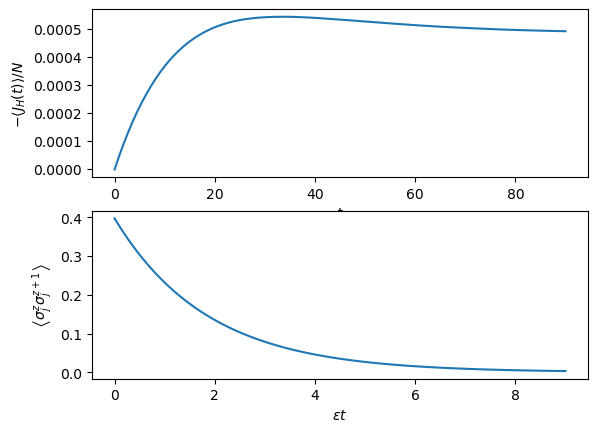

In [189]:
plt.subplot(211)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/avg_current.txt", unpack=True)

plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 


plt.subplot(212)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/force_3/spin_neighbor_correlation.txt", unpack=True)

plt.plot(EPSILON * t_eval, Y)
plt.xlabel(r'$\epsilon t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')


plt.savefig("results/time_dependent_GGE/heisenberg_spins/force_3/observables_GGE.pdf")

Plot comparison with exact time evolution


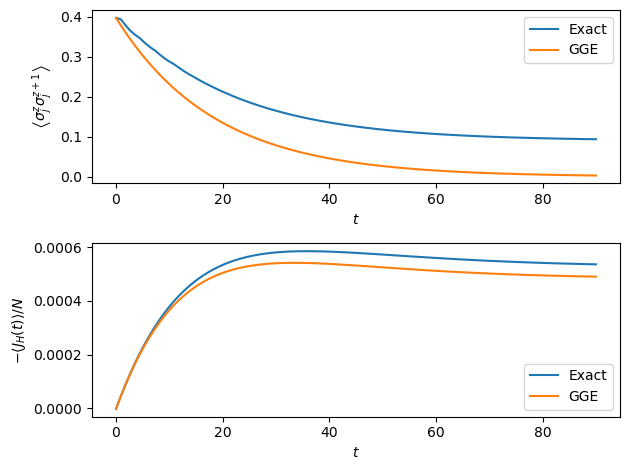

In [197]:
folder = 'force_3'

plt.subplot(2, 1, 2)

t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.legend()



plt.subplot(2, 1, 1)
t_eval, Y = np.loadtxt(f"results/time_dependent_GGE/heisenberg_spins/{folder}/spin_neighbor_correlation.txt", unpack=True)
Y_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

plt.plot(ts, Y_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()

plt.gcf()
plt.tight_layout()

plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/{folder}/observables_exact_VS_GGE.pdf")


In [196]:
(Ob_val @ C2 - C2 @ Ob_val).toarray()

array([[0.+0.j , 0.+0.j , 0.+0.j , ..., 0.+0.j , 0.+0.j , 0.+0.j ],
       [0.+0.j , 0.+0.j , 0.+0.5j, ..., 0.+0.j , 0.+0.j , 0.+0.j ],
       [0.+0.j , 0.-0.5j, 0.+0.j , ..., 0.+0.j , 0.+0.j , 0.+0.j ],
       ...,
       [0.+0.j , 0.+0.j , 0.+0.j , ..., 0.+0.j , 0.-0.5j, 0.+0.j ],
       [0.+0.j , 0.+0.j , 0.+0.j , ..., 0.+0.5j, 0.+0.j , 0.+0.j ],
       [0.+0.j , 0.+0.j , 0.+0.j , ..., 0.+0.j , 0.+0.j , 0.+0.j ]])